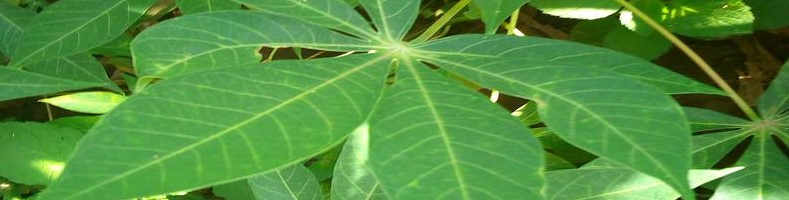

* This notebook is an ongoing effort to build an image classifier for Cassava leaf disease classification. 
* [Check out this kernel for inference](https://www.kaggle.com/ayuraj/tensorflow-inference-no-tta?scriptVersionId=51996234)

If you like the work please upvote! :D

# 💥 Includes

* Starter code for training EfficientNet model using TensorFlow(Keras).
* Training and validation data pipeline using `tf.data`.
* Data augmetation - Gaussian Blur, Color Jitter, Color Drop and **Mixup**.
* K-Fold cross validation training.
* Experiment tracking using Weights and Biases.


# 🧰 Setups, Installations and Imports

In [ ]:
%%capture
!pip install wandb --upgrade

Since TensorFlow >2.3 is not available with TPU based session, we will be using this repo to use the efficientnet model as backbone.

In [ ]:
%%capture
!pip install git+https://github.com/qubvel/efficientnet.git

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import tensorflow_probability as tfp
tfd = tfp.distributions

import efficientnet.keras as efn 

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from functools import partial

In [ ]:
# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

We will use [Weights and Biases](https://wandb.ai/site) for experiment tracking.

In [ ]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api")

wandb.login(key=wandb_api)

## ⚡ Setup TPU and Distribution Strategy

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

# 📀 Set Hyperparameters 

For a more through EDA check out this [excellent Kernel](https://www.kaggle.com/ihelon/cassava-leaf-disease-exploratory-data-analysis). **Note: There is class imbalance.**

In [ ]:
from kaggle_datasets import KaggleDatasets

GCS_PATH = KaggleDatasets().get_gcs_path()
IMAGE_SIZE = 380
BATCH_SIZE = 128*strategy.num_replicas_in_sync

AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASS_NUMS = 5

WORK_DIR = '../input/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

# 🐋 Utilities

In [ ]:
# Decode image from TFRecord file.
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
#     image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    return image

def decode_valid_image(image, label):
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    return image, label

# Read the TFRecord file.
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        label = tf.one_hot(label, depth=CLASS_NUMS)
        return image, label
    idnum = example['image_name']
    return image, idnum

# Return tf.data dataset
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

# 💪 Augmentation Policies

In [ ]:
@tf.function
def gaussian_blur(image, kernel_size=23, padding='SAME'):
	sigma = tf.random.uniform((1,))* 1.9 + 0.1

	radius = tf.cast(kernel_size / 2, tf.int32)
	kernel_size = radius * 2 + 1
	x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
	blur_filter = tf.exp(
		-tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, tf.float32), 2.0)))
	blur_filter /= tf.reduce_sum(blur_filter)
	# One vertical and one horizontal filter.
	blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
	blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
	num_channels = tf.shape(image)[-1]
	blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
	blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
	expand_batch_dim = image.shape.ndims == 3
	if expand_batch_dim:
		image = tf.expand_dims(image, axis=0)
	blurred = tf.nn.depthwise_conv2d(
		image, blur_h, strides=[1, 1, 1, 1], padding=padding)
	blurred = tf.nn.depthwise_conv2d(
		blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
	if expand_batch_dim:
		blurred = tf.squeeze(blurred, axis=0)
	return blurred

@tf.function
def color_jitter(x, s=0.5):
	x = tf.image.random_brightness(x, max_delta=0.8*s)
	x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
	x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
	x = tf.image.random_hue(x, max_delta=0.2*s)
	x = tf.clip_by_value(x, 0, 1)
	return x

@tf.function
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMAGE_SIZE, IMAGE_SIZE, 3])

  return cropped_image

@tf.function
def random_apply(func, x, p):
	return tf.cond(
		tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
				tf.cast(p, tf.float32)),
		lambda: func(x),
		lambda: x)

@tf.function
def custom_augment(image, label):
    # Random Crop
    image = random_crop(image)
    
    # Random flip
    image = random_apply(tf.image.flip_left_right, image, p=0.5)
    image = random_apply(tf.image.flip_up_down, image, p=0.5)
    
    # Randomly apply gausian blur
    image = random_apply(gaussian_blur, image, p=0.5)
    
    # Randomly apply transformation (color distortions) with probability p.
    image = random_apply(color_jitter, image, p=0.5)
    
    return image, label

# 🎶 Mixup

In [ ]:
def mixup(a, b):
  alpha = [0.2]

  (image1, label1), (image2, label2) = a, b

  dist = tfd.Beta(alpha, alpha)
  l = dist.sample(1)[0][0]
  
  img = l*image1+(1-l)*image2
  lab = l*label1+(1-l)*label2

  return img, lab

# ⛄ Prepare Dataloader


In [ ]:
def get_dataloader(training_filenames, valid_filenames):
    trainloader1 = load_dataset(training_filenames).shuffle(1024).map(custom_augment, num_parallel_calls=AUTOTUNE)
    trainloader2 = load_dataset(training_filenames).shuffle(1024).map(custom_augment, num_parallel_calls=AUTOTUNE)

    validloader = load_dataset(valid_filenames)

    trainloader = tf.data.Dataset.zip((trainloader1, trainloader2))

    trainloader = (
        trainloader
        .map(mixup, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )

    validloader = (
        validloader
        .map(decode_valid_image, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )
    
    return trainloader, validloader

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

TRAINING_TFRECORDS = np.array(tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'))     
trainloader, validloader = get_dataloader(TRAINING_TFRECORDS[0], TRAINING_TFRECORDS[1])
    

image_batch, label_batch = next(iter(trainloader))
show_batch(image_batch, label_batch)

# 🐤 Model

In [ ]:
def get_model():
  efn_model = efn.EfficientNetB4(weights='noisy-student')
  base_model = Model(inputs=efn_model.input, outputs=efn_model.layers[-3].output)
  base_model.trainabe = True

  inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
  x = base_model(inputs, training=True)
  x = Dropout(0.5)(x)
  outputs = Dense(CLASS_NUMS, activation='softmax')(x)

  return Model(inputs, outputs)

tf.keras.backend.clear_session()
model = get_model()
model.summary()

# 📲 Callbacks

We will be using the following callbacks:

* Early Stopping - Terminate model training when the `val_loss` degrades for over `patience` epochs
* WandbCallback - To monitor model performance and system metrics.

In [ ]:
earlystoper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=0, mode='auto',
    restore_best_weights=True
)

# 👀 Learning Rate Scheduling

In [ ]:
# lr = 0.0003*strategy.num_replicas_in_sync
# SCHEDULE_BOUNDARIES = [50, 200, 300]

# lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
#                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])

# total_num_steps = 16*EPOCHS
# rang = np.arange(total_num_steps)
# y = [lr_schedule(x).numpy() for x in rang]
# plt.plot(rang, y)
# print('Learning rate per epoch:')

In [ ]:
EPOCHS = 25

start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.0005 * strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 5
exp_decay = .9

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

# 🚋 Train with W&B

In [ ]:
EPOCHS = 25

# Stratified K-Fold Strategy
skf = KFold(n_splits=5, shuffle=True, random_state=42)
# Get training TFRecords
TRAINING_TFRECORDS = np.array(tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'))

ACCUMULATED_VAL_ACC = []

# Train for each fold and save model
for fold, (train_index, test_index) in enumerate(skf.split(TRAINING_TFRECORDS)):
    # reinitialize TPU
    if tpu:
        tf.tpu.experimental.initialize_tpu_system(tpu)
        
    print(f"FOLD NUMBER:{fold} , TRAIN IDX: {train_index}, TEST IDX: {test_index}")
    
    # Get train-validation split for this fold
    TRAINING_FILENAMES, VALID_FILENAMES = TRAINING_TFRECORDS[train_index.tolist()], TRAINING_TFRECORDS[test_index.tolist()]
    # Get train and validation dataloader
    trainloader, validloader = get_dataloader(TRAINING_FILENAMES, VALID_FILENAMES)
    
    # Initialize model
    tf.keras.backend.clear_session()
    with strategy.scope():
        model = get_model()
        
#         optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
        model.compile('adam', 'categorical_crossentropy', metrics=['acc'])
    
    # Initialize W&B run for experiment tracking
    wandb.init(entity='ayush-thakur', project='cassava', job_type='train', name=f'fold_{fold}')

    # Train model 
    _ = model.fit(trainloader,
              epochs=EPOCHS,
              validation_data=validloader,
              callbacks=[earlystoper,
                         lr_callback,
                         WandbCallback()])
    
    # Save best instance of the model.
    model.save(f'model_efficientnet_fold_{fold}.h5')
    
    # Evaluate model on hold out validation set for this fold.
    loss, val_acc = model.evaluate(validloader)
    ACCUMULATED_VAL_ACC.append(val_acc)
    wandb.log({'val acc for fold': val_acc})
    
    del model
    del trainloader
    del validloader
    
    # Close run for that fold
    wandb.join()

**Click on the project link above to go to the Weights and Biases dashboard.**

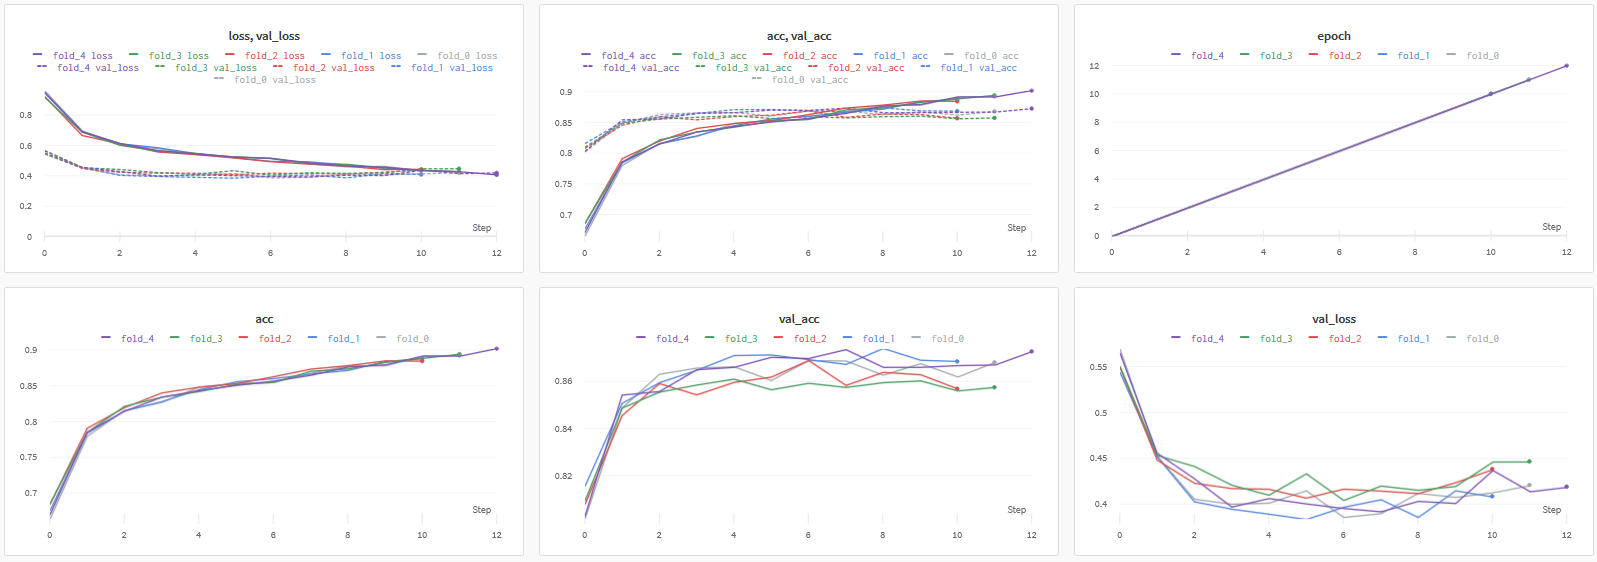

In [ ]:
print(f'Average Model Accuracy: {np.mean(ACCUMULATED_VAL_ACC)}')

# ⚗️ Save Model for Inference

We will also save the model as W&B artifacts for model versioning.

In [ ]:
model_files = [file for file in os.listdir('./') if file.endswith('.h5')]
model_files

In [ ]:
wandb.init(entity='ayush-thakur', project='cassava', job_type='producer')

artifact = wandb.Artifact('model', type='model')

for model_file in model_files:
    artifact.add_file(model_file)

wandb.log_artifact(artifact)
wandb.join()